# Dog Breed Classifier  

In this notebook, we explore the dog breed classifier algorithm and break down each step of the pipeline with some analysis

In [1]:
# Enable auto reloading of notebook
%load_ext autoreload
%autoreload 2

In [2]:
# Import modules
import random

random.seed(8675309)
import torch
import cv2
import numpy as np
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN, InceptionResnetV1
from sklearn.metrics import precision_recall_fscore_support
from PIL import Image
from utils import (
    load_dog_dataset,
    load_human_dataset,
    get_num_faces_mtcnn,
    get_num_faces_haarcascade,
    visualize_faces_mtcnn,
    visualize_faces_haarcascade,
    detect_dog_imagenet,
)
from dog_breed_classifier import DogBreedClassifierPipeline
from networks import SimpleNet, VGGTransferLearningNet, ResNetTransferLearningNet
from dog_app import DogApp

In [3]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using {}".format(device))

Using cuda:0


## 0. Load Data

### Load Dog Dataset

In [4]:
# Load dog dataset
train_files, train_targets, dog_targets_map = load_dog_dataset("data/dogImages/train")
valid_files, _, _ = load_dog_dataset("data/dogImages/valid")
test_files, _, _ = load_dog_dataset("data/dogImages/test")

# Load list of dog names
dog_names = dog_targets_map.values()

# Print statistics about the dataset
print("There are %d total dog categories." % len(dog_names))
print(
    "There are %s total dog images."
    % len(np.hstack([train_files, valid_files, test_files]))
)
print("There are %d training dog images." % len(train_files))
print("There are %d validation dog images." % len(valid_files))
print("There are %d test dog images." % len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.
There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


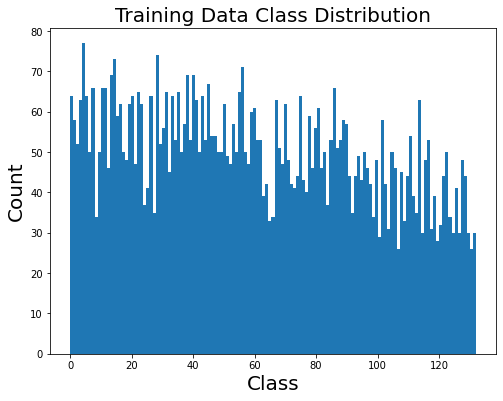

In [5]:
fig = plt.figure(figsize=(8, 6))
plt.title("Training Data Class Distribution", size=20)
plt.ylabel("Count", size=20)
plt.xlabel("Class", size=20)
plt.hist(train_targets, bins=len(dog_names))
plt.show()

Looking at the training data class distribution, we see that the classes are not entirely even but the distribution does not look too unbalanced

### Load Human Dataset

In [6]:
# Load human dataset
human_files = load_human_dataset("data/lfw")
random.shuffle(human_files)

# Print statistics about the dataset
print("There are %d total human images." % len(human_files))

There are 13233 total human images.


## 1. Human Detector

Here we consider two human face detectors, [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) and [Face recognition using PyTorch](https://github.com/timesler/facenet-pytorch).

For our assessment we consider four metrics:
- Accuracy: We want to know how correct the algorithm is
- Precision: We want to know out of all the positive results how many of them are correct
- Recall: We want to know out of all the relevant results (human images in this case) how many of them will be correct
- F-score: This score unifies precision and recall into one metric

Number of detected faces:  1


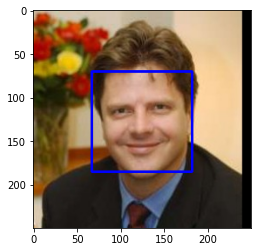

In [7]:
# Haarcascade
face_cascade = cv2.CascadeClassifier(
    "pretrained/haarcascades/haarcascade_frontalface_alt.xml"
)
print(
    "Number of detected faces: ",
    get_num_faces_haarcascade(str(human_files[0]), face_cascade),
)
visualize_faces_haarcascade(str(human_files[0]), face_cascade)

Number of detected faces:  1


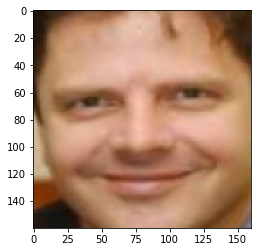

In [8]:
# PyTorch
mtcnn = MTCNN(image_size=160, keep_all=True, device=device)
print("Number of detected faces: ", get_num_faces_mtcnn(str(human_files[0]), mtcnn))
visualize_faces_mtcnn(str(human_files[0]), mtcnn)

In [9]:
# Get sample to analyze
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

In [10]:
def assess_human_detector(human_files, dog_files, get_num_faces):
    """
    Assess the human detector
    Input:
        human_files: List of files of human images
        dog_files: List of files of dog images
        get_num_faces (x): Lambda function that takes in an image path
                           and outputs the number of human faces present in the image
    """
    num_true_positive = 0
    y_true = [0] * len(human_files) + [1] * len(dog_files)
    y_pred = []
    for x in human_files:
        next_pred = get_num_faces(x) > 0
        y_pred.append(0) if next_pred else y_pred.append(1)
        num_true_positive += 1 if next_pred else 0

    num_false_positive = 0
    for x in dog_files:
        next_pred = get_num_faces(x) > 0
        y_pred.append(0) if next_pred else y_pred.append(1)
        num_false_positive += 1 if next_pred else 0

    print(
        "Human faces correctly detected: {}/{}".format(
            num_true_positive, len(human_files)
        )
    )
    print(
        "Dog faces wrongly detected as human: {}/{}".format(
            num_false_positive, len(dog_files)
        )
    )
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=0
    )

    accuracy = (num_true_positive + (len(dog_files) - num_false_positive)) / 200

    print("Accuracy: {}".format(accuracy))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("Fscore: {}".format(fscore))

In [11]:
print("Using Haar Cascade")
assess_human_detector(
    human_files_short,
    dog_files_short,
    lambda x: get_num_faces_haarcascade(str(x), face_cascade),
)

Using Haar Cascade
Human faces correctly detected: 97/100
Dog faces wrongly detected as human: 19/100
Accuracy: 0.89
Precision: 0.8362068965517241
Recall: 0.97
Fscore: 0.8981481481481481


In [12]:
print("Using MTCNN")
assess_human_detector(
    human_files_short, dog_files_short, lambda x: get_num_faces_mtcnn(str(x), mtcnn)
)

Using MTCNN
Human faces correctly detected: 96/100
Dog faces wrongly detected as human: 27/100
Accuracy: 0.845
Precision: 0.7804878048780488
Recall: 0.96
Fscore: 0.8609865470852018


We see that overall the **Haar Cascade algorithm** does better than MTCNN on all metrics

## 2. Dog Detector

In [13]:
def assess_dog_detector(human_files, dog_files, detector, device):
    """
    Assess the human detector
    Input:
        human_files: List of files of human images
        dog_files: List of files of dog images
        detector: Machine learning model
        device: Name of device to use e.g. "cuda: 0" for GPU or "cpu"
    """
    num_true_positive = 0
    y_true = [1] * len(dog_files) + [0] * len(human_files)
    y_pred = []
    for x in dog_files:
        next_pred = detect_dog_imagenet(str(x), detector, device)
        y_pred.append(1) if next_pred else y_pred.append(0)
        num_true_positive += 1 if next_pred else 0

    num_false_positive = 0
    for x in human_files:
        next_pred = detect_dog_imagenet(str(x), detector, device)
        y_pred.append(1) if next_pred else y_pred.append(0)
        num_false_positive += 1 if next_pred else 0

    print("Dogs correctly detected: {}/{}".format(num_true_positive, len(dog_files)))
    print(
        "Humans wrongly classified as dog: {}/{}".format(
            num_false_positive, len(human_files)
        )
    )
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=1
    )

    accuracy = (num_true_positive + (len(human_files) - num_false_positive)) / 200

    print("Accuracy: {}".format(accuracy))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("Fscore: {}".format(fscore))

In [14]:
def count_parameters(model):
    """
    Count number of parameters in the model
    Input:
        model: Machine learning model
    Output:
        Number of parameters in the model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
print("Using Resnet50")
resnet50 = models.resnet50(pretrained=True).to(device).eval()
print("Number of parameters: {}".format(count_parameters(resnet50)))
assess_dog_detector(human_files_short, dog_files_short, resnet50, device)

Using Resnet50
Number of parameters: 25557032
Dogs correctly detected: 98/100
Humans wrongly classified as dog: 0/100
Accuracy: 0.99
Precision: 1.0
Recall: 0.98
Fscore: 0.98989898989899


In [16]:
print("Using VGG16")
vgg16 = models.vgg16(pretrained=True).to(device).eval()
print("Number of parameters: {}".format(count_parameters(vgg16)))
assess_dog_detector(human_files_short, dog_files_short, vgg16, device)

Using VGG16
Number of parameters: 138357544
Dogs correctly detected: 100/100
Humans wrongly classified as dog: 0/100
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Fscore: 1.0


In [17]:
print("Using Inception V3")
inception_v3 = models.inception_v3(pretrained=True).to(device).eval()
print("Number of parameters: {}".format(count_parameters(inception_v3)))
assess_dog_detector(human_files_short, dog_files_short, inception_v3, device)

Using Inception V3
Number of parameters: 27161264
Dogs correctly detected: 100/100
Humans wrongly classified as dog: 4/100
Accuracy: 0.98
Precision: 0.9615384615384616
Recall: 1.0
Fscore: 0.9803921568627451


We see that overall **VGG16** beats the other models

## 3. Dog Breed Classifier From Scratch

In this section, we design a convolutional neural network model to classify dog breeds. We then train and evaluate our model. Evaluation is carried out using the same metrics as before. However, note in this class we are dealing with a multi-class problem (instead of binary). 

During the training of our model, we augment our data by 
- random horizontal flipping
- randomly cropping segments of the image
- randomly shifting the colour of the image

We fix our model to train for 20 epochs with cross entropy loss and Adam optimizer with a learning rate of 3e-4. We also regularly validate the model on the validation set and keep the model with the lowest validation score as our chosen model.

In [18]:
simple_net = SimpleNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_net.parameters(), lr=3e-4)

In [19]:
print(simple_net)

SimpleNet(
  (cnn_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=6272, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=

In [20]:
dog_breed_classifier_pipeline = DogBreedClassifierPipeline(
    data_path="data/dogImages", model=simple_net, save_prefix="scratch"
)

In [21]:
# Train the model
# Takes a while depending on your computation
# Alternatively, skip this step and use the pretrained model
# dog_breed_classifier_pipeline.train(num_epochs=20, loss_fn=loss_fn, optimizer=optimizer, device=device)

In [22]:
dog_breed_classifier_pipeline.load(
    "pretrained/saved_models/scratch_2021_10_10_111153599424_06600_best.pt"
)

Loading model from checkpoint pretrained/saved_models/scratch_2021_10_10_111153599424_06600_best.pt


In [23]:
print("Using model designed from scratch")
dog_breed_classifier_pipeline.evaluate(device)

Using model designed from scratch
Accuracy: 0.12679425837320574
Precision: 0.095824094619865
Recall: 0.1081185105621196
Fscore: 0.08330003562433701


Hmm, our results don't look too satisfactory

## 4. Dog Breed Classifier With Transfer Learning

Now, we modify our method with a transfer learning solution. We use popular pretrained models and modify their final layers to suit our prolblem. Then we freeze the feature extraction layers and train only the final layers. Besides the model, the training setup is similar to before. We compare transfer learning on VGG16 as well as ResNet50.

In [24]:
resnet50_dogbreed_net = ResNetTransferLearningNet(models.resnet50(pretrained=True)).to(
    device
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_dogbreed_net.parameters(), lr=3e-4)

In [25]:
dog_breed_classifier_pipeline = DogBreedClassifierPipeline(
    data_path="data/dogImages", model=resnet50_dogbreed_net, save_prefix="resnet50_tf"
)

In [26]:
# Train the model
# Takes a while depending on your computation
# Alternatively, skip this step and use the pretrained model
# dog_breed_classifier_pipeline.train(num_epochs=20, loss_fn=loss_fn, optimizer=optimizer, device=device)

In [27]:
dog_breed_classifier_pipeline.load(
    "pretrained/saved_models/resnet50_tf_2021_10_11_180421188539_06300_best.pt"
)

Loading model from checkpoint pretrained/saved_models/resnet50_tf_2021_10_11_180421188539_06300_best.pt


In [28]:
print("Using ResNet50 with transfer learning")
dog_breed_classifier_pipeline.evaluate(device)

Using ResNet50 with transfer learning
Accuracy: 0.8480861244019139
Precision: 0.8581738437001594
Recall: 0.8367555794247522
Fscore: 0.8343678953091415


For the VGG16 pretrained model, please download it from [here](https://drive.google.com/file/d/1V95M1Aaz9Vd_BDO7pKYavwBRt7HB5dt7/view?usp=sharing).

In [29]:
# vgg16_dogbreed_net = VGGTransferLearningNet(vgg16).to(device)
# dog_breed_classifier_pipeline = DogBreedClassifierPipeline(
#     data_path="data/dogImages", model=vgg16_dogbreed_net, save_prefix="vgg16_tf"
# )
# dog_breed_classifier_pipeline.load(
#     "pretrained/saved_models/vgg16_tf_2021_10_10_102658274148_03900_best.pt"
# )
# print("Using VGG16 with transfer learning")
# dog_breed_classifier_pipeline.evaluate(device)

Loading model from checkpoint pretrained/saved_models/vgg16_tf_2021_10_10_102658274148_03900_best.pt
Using VGG16 with transfer learning
Accuracy: 0.7751196172248804
Precision: 0.7958105570776955
Recall: 0.760890321040697
Fscore: 0.7493375612462113


Using transfer learning we've managed to increase our accuracy from 12% to 83%!. Notice that the **ResNet50 model with transfer learning** is overall better than the VGG16 model with transfer learning given our chosen metrics. It is expected that the VGG16 model does better than the ResNet50 model given that it has more parameters. However, given that VGG16 has more parameters it would also need more time and data to train. 

## Final Algorithm

Finally, we put everything together to develop an algorithm that takes in an image and identifies if contains a human or a dog. If it does contain either a human or a dog, a convolutional neural network (CNN) will classify the dog's breed or the resembling dog breed for that human.

In [30]:
dog_breed_classifier_fn = lambda x: dog_breed_classifier_pipeline.classify(x, device)
dog_detector_fn = lambda x: detect_dog_imagenet(x, resnet50, device)
human_detector_fn = lambda x: get_num_faces_haarcascade(str(x), face_cascade)
dog_app = DogApp(dog_breed_classifier_fn, dog_detector_fn, human_detector_fn)

In [31]:
def get_app_output(img_path):
    """
    Run the application and get the output
    Input:
        img_path (string): Path to input image
    """
    output = dog_app.run(img_path)
    img = Image.open(img_path).convert("RGB")
    plt.yticks([])
    plt.xticks([])
    plt.imshow(img)
    plt.show()
    print(output)

In [32]:
test_images = [
    train_files[311],
    test_files[311],
    valid_files[500],
    human_files[456],
    "media/three_people.jpg",
    "media/ngenge.jpeg",
]

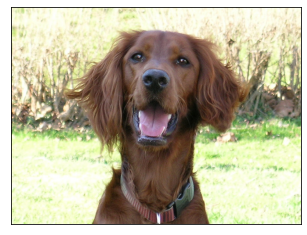

This is a Irish setter dog


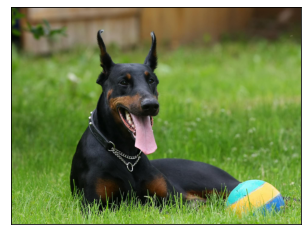

This is a Doberman pinscher dog


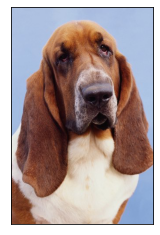

This is a Basset hound dog


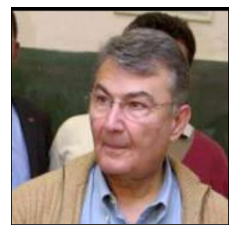

Not a dog but looks like a Pharaoh hound


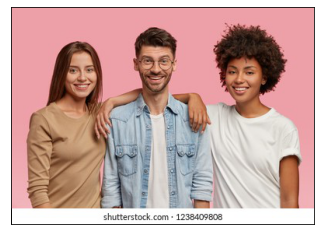

Not a dog but looks like a Chinese crested


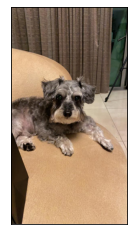

Can't tell if human or dog. Either way looks like a Miniature schnauzer


In [33]:
for x in test_images:
    get_app_output(x)